In [45]:
# pip install yfinance

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [47]:
# pulling the data from last 1 year
crypto_symbol = 'BTC-USD'
prediction_ahead = 15
btc_data = yf.download(crypto_symbol, period='1y', interval = '1d')
btc_data = btc_data[['Close']].dropna()
display(btc_data.head())

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2024-12-03,96002.164062
2024-12-04,98768.531250
2024-12-05,96593.570312
2024-12-06,99920.710938
2024-12-07,99923.335938


[*********************100%***********************]  1 of 1 completed


Saved as btc_prices.csv

Missing Data Count:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64


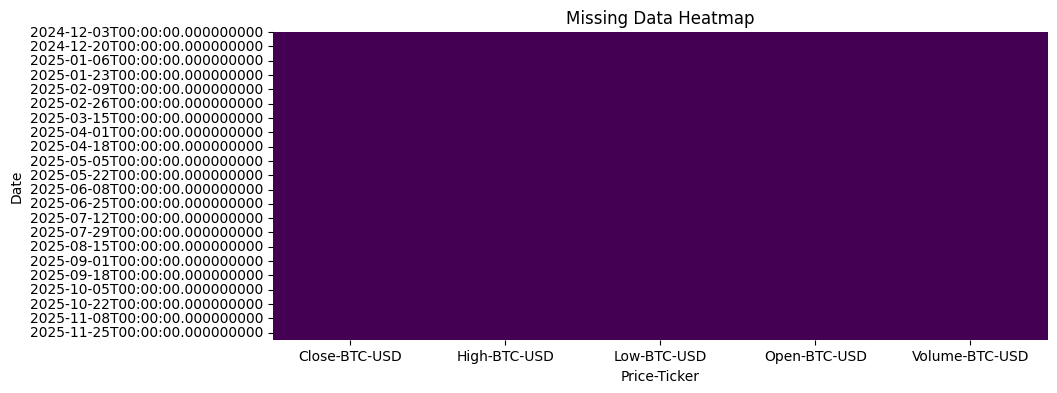


Data Description:
Price           Close           High            Low           Open  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count      366.000000     366.000000     366.000000     366.000000   
mean    102364.315766  103977.506446  100579.288828  102371.772370   
std      11230.349440   11094.887907   11430.170758   11225.552651   
min      76271.953125   80823.890625   74436.679688   76273.562500   
25%      94586.677734   95968.925781   92973.283203   94666.765625   
50%     103723.925781  105397.570312  101491.984375  103722.496094   
75%     110977.412109  112549.423828  109371.894531  110977.341797   
max     124752.531250  126198.070312  123196.046875  124752.140625   

Price         Volume  
Ticker       BTC-USD  
count   3.660000e+02  
mean    5.481889e+10  
std     2.498878e+10  
min     9.863214e+09  
25%     3.734962e+10  
50%     5.155519e+10  
75%     6.938983e+10  
max     1.817464e+11  


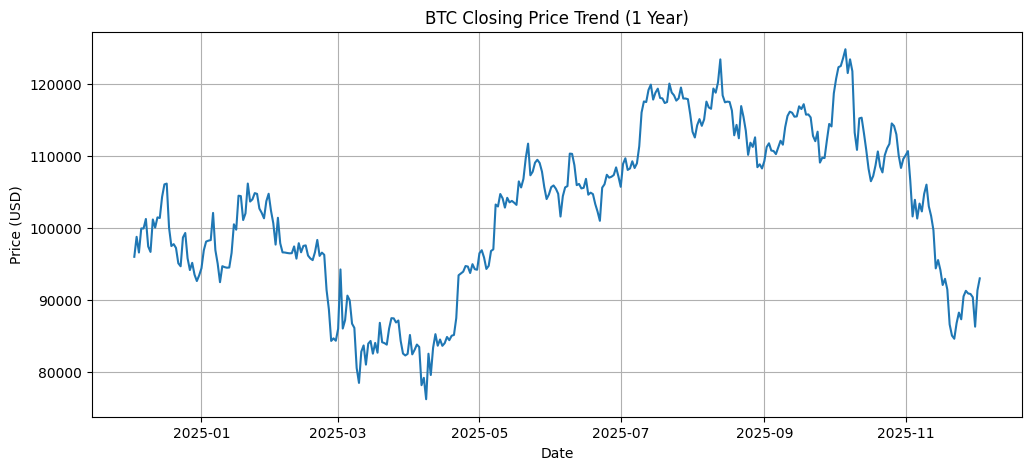

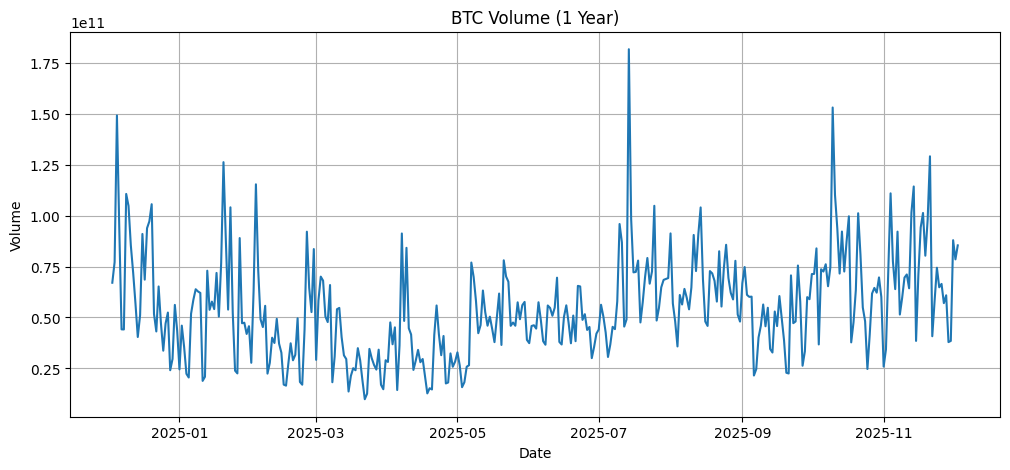

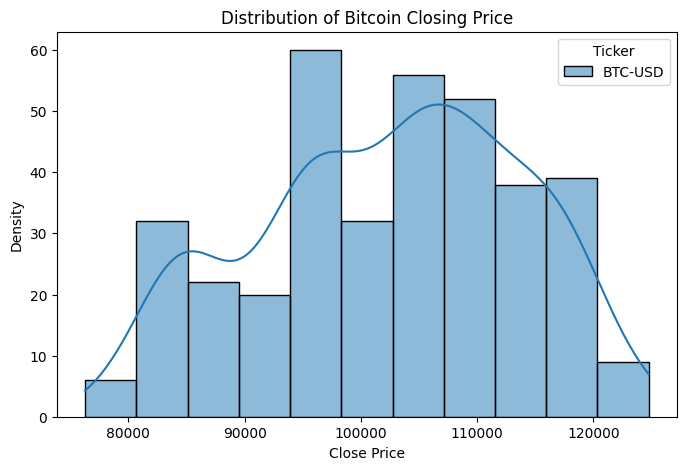

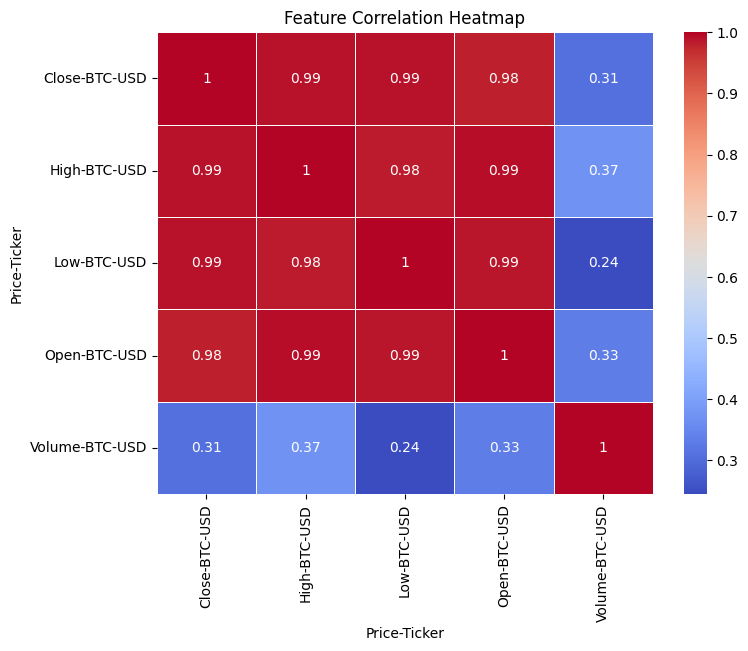

In [48]:
btc_data.to_csv("btc_prices.csv", index=True)
print("Saved as btc_prices.csv")

crypto_symbol = 'BTC-USD'
btc_data = yf.download(crypto_symbol, period='1y', interval='1d')

# Basic Cleanup
btc_data = btc_data.dropna()

# ---- Missing Data Check ----
print("\nMissing Data Count:")
print(btc_data.isnull().sum())

plt.figure(figsize=(10, 4))
sns.heatmap(btc_data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

print("\nData Description:")
print(btc_data.describe())

# Plot Close Price Trend
plt.figure(figsize=(12, 5))
plt.plot(btc_data['Close'])
plt.title("BTC Closing Price Trend (1 Year)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

# Plot Volume Trend
plt.figure(figsize=(12, 5))
plt.plot(btc_data['Volume'])
plt.title("BTC Volume (1 Year)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()

# Distribution of Close Price
plt.figure(figsize=(8, 5))
sns.histplot(btc_data['Close'], kde=True)
plt.title("Distribution of Bitcoin Closing Price")
plt.xlabel("Close Price")
plt.ylabel("Density")
plt.show()

# ---- Correlation Heatmap ----
plt.figure(figsize=(8, 6))
corr = btc_data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [49]:
#  data preprocessing

In [50]:
# prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
# FIX: Fit the scaler only on the 'Close' column, which is the feature the model predicts.
scaled_data = scaler.fit_transform(btc_data[['Close']])

# correct split for training and tetsing dataset
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=1):
  X,y = [],[]
  for i in range(len(data) - time_step):
    X.append(data[i:(i+time_step), 0])
    y.append(data[i + time_step ,0 ])
  return np.array(X), np.array(y)

# use 80% of the total data for training and 20% for testing
time_step = 60
X_train, y_train = create_dataset(scaled_data[:train_size], time_step)
X_test, y_test = create_dataset(scaled_data[train_size - time_step:], time_step)

# reshape input to be [samples, time steps,features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [51]:
# X_train[0:10]
y_train[0:10]

array([0.50296333, 0.44176502, 0.51842345, 0.4455365 , 0.41962149,
       0.41916463, 0.41784017, 0.41687828, 0.41724215, 0.43657898])

Build LSTM model

In [52]:
# building LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 1, epochs = 5, verbose = 1)

# make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0340
Epoch 2/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0089
Epoch 3/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0046
Epoch 4/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0059
Epoch 5/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0043
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [53]:
# forecasting ahead
last_60_days = scaled_data[-time_step:]
future_input = last_60_days.reshape(1, time_step,1)
future_forecast = []
for _ in range(prediction_ahead):
  next_pred = model.predict(future_input)[0,0]
  future_forecast.append(next_pred)
  next_input = np.append(future_input[0,1:], [[next_pred]], axis = 0)
  future_input = next_input.reshape(1, time_step, 1)

future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# latest price and las predicted price
latest_close_price = float(btc_data['Close'].iloc[-1])
last_predicted_price = float(future_forecast[-1])

# print metrics
print(f"Latest Close Price: ${latest_close_price :,.2f}")
print(f"Price After {prediction_ahead} Days: ${last_predicted_price:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Latest Close Price: $93,011.91
Price After 15 Days: $93,414.13


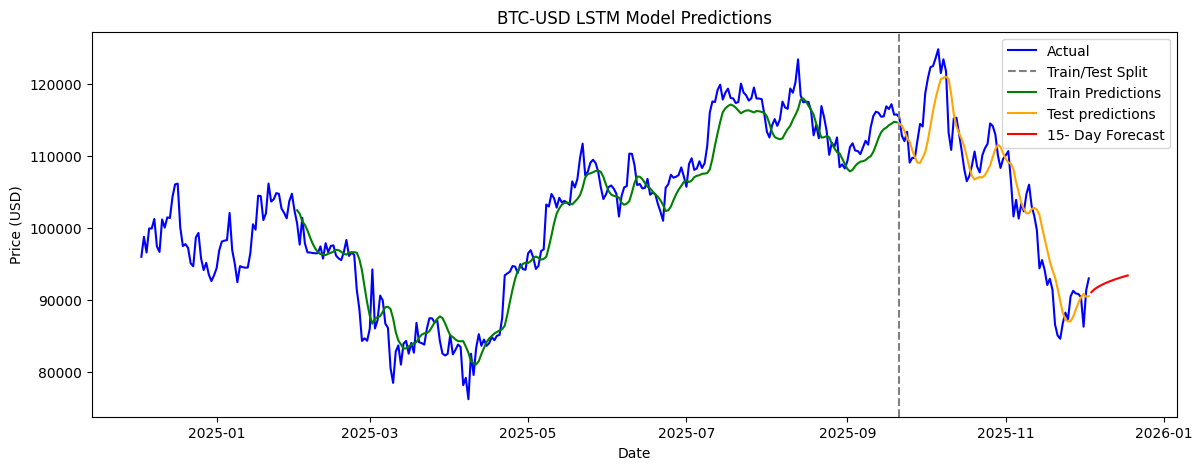

In [54]:
# plot the result
plt.figure(figsize=(14, 5))
plt.plot(btc_data.index, btc_data['Close'], label='Actual', color='blue')
plt.axvline(x= btc_data.index[train_size], color= 'gray',linestyle='--',label ="Train/Test Split")

# Train/Test predictions
train_range = btc_data.index[time_step : train_size]
test_range = btc_data.index[train_size : train_size + len(test_predictions)]
plt.plot(train_range, train_predictions, label='Train Predictions', color='green')
plt.plot(test_range, test_predictions, label='Test predictions', color='orange')

# future predictions
future_index = pd.date_range(start=btc_data.index[-1], periods=prediction_ahead + 1, freq='D')[1:]
plt.plot(future_index, future_forecast, label=f'{prediction_ahead}- Day Forecast', color='red')

plt.title(f"{crypto_symbol} LSTM Model Predictions")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2024-12-03,96002.164062,96297.203125,93629.562500,95854.593750,67067810961
2024-12-04,98768.531250,99207.328125,94660.523438,95988.531250,77199817112
2024-12-05,96593.570312,103900.468750,91998.781250,98741.539062,149218945580
2024-12-06,99920.710938,102039.882812,96514.875000,97074.226562,94534772658
2024-12-07,99923.335938,100563.382812,99030.882812,99916.710938,44177510897


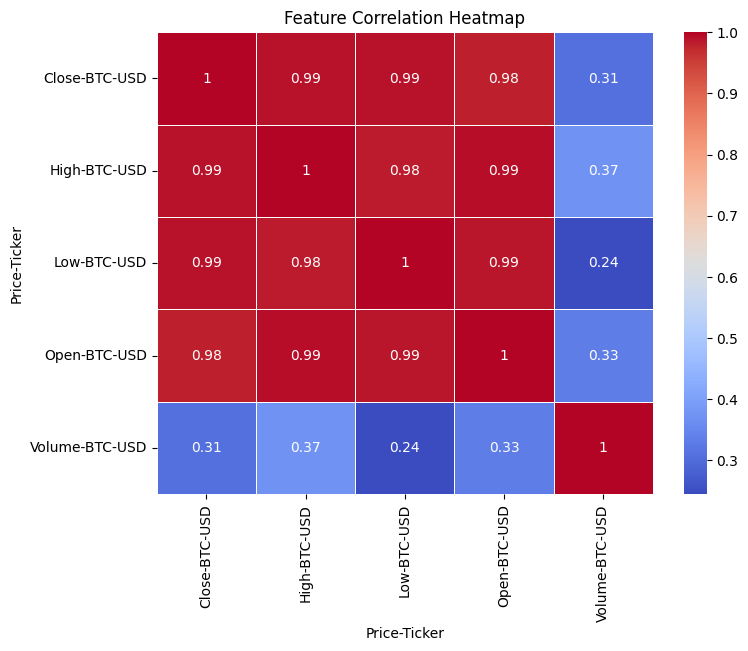

Epoch 1/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0308
Epoch 2/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0099
Epoch 3/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0056
Epoch 4/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0046
Epoch 5/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0045
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Latest Close Pric

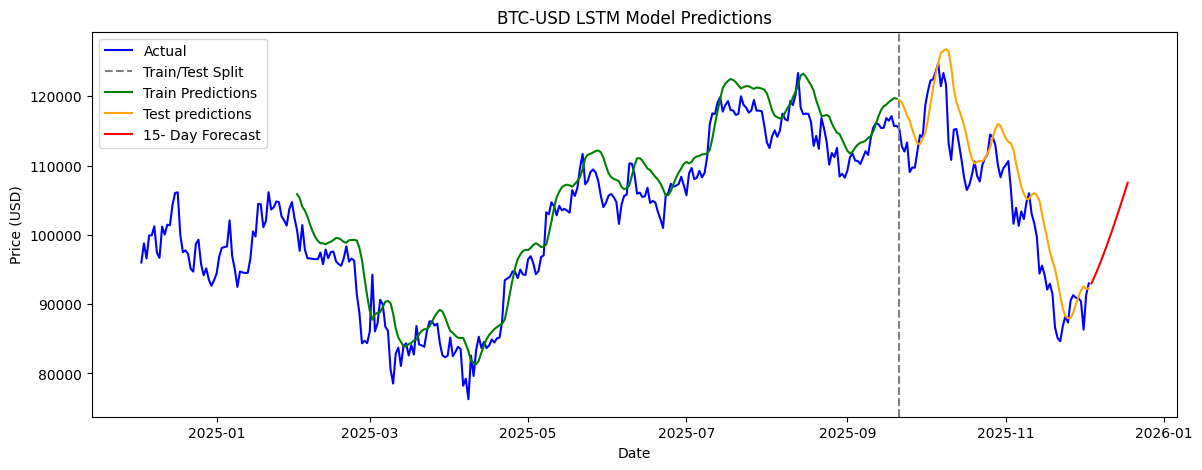

In [55]:
# rnning all together
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns # Ensure seaborn is imported for heatmap
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# pulling the data from last 1 year
crypto_symbol = 'BTC-USD'
prediction_ahead = 15
# Download all relevant data first
btc_data = yf.download(crypto_symbol, period='1y', interval = '1d')
btc_data = btc_data.dropna() # Drop rows with any missing values across all columns
display(btc_data.head())

# ---- Correlation Heatmap (now with all columns) ----
plt.figure(figsize=(8, 6))
corr = btc_data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Now, select only the 'Close' column for LSTM model training
btc_data_close = btc_data[['Close']]

# prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
# FIX: Fit the scaler only on the 'Close' column, which is the feature the model predicts.
scaled_data = scaler.fit_transform(btc_data_close)

# correct split for training and tetsing dataset
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=1):
  X,y = [],[]
  for i in range(len(data) - time_step):
    X.append(data[i:(i+time_step), 0])
    y.append(data[i + time_step ,0 ])
  return np.array(X), np.array(y)

# use 80% of the total data for training and 20% for testing
time_step = 60
X_train, y_train = create_dataset(scaled_data[:train_size], time_step)
X_test, y_test = create_dataset(scaled_data[train_size - time_step:], time_step)

# reshape input to be [samples, time steps,features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# X_train[0:10]
y_train[0:10]

# building LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size = 1, epochs = 5, verbose = 1)

# make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# forecasting ahead
last_60_days = scaled_data[-time_step:]
future_input = last_60_days.reshape(1, time_step,1)
future_forecast = []
for _ in range(prediction_ahead):
  next_pred = model.predict(future_input)[0,0]
  future_forecast.append(next_pred)
  next_input = np.append(future_input[0,1:], [[next_pred]], axis = 0)
  future_input = next_input.reshape(1, time_step, 1)

future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# latest price and las predicted price
latest_close_price = float(btc_data_close['Close'].iloc[-1]) # Use btc_data_close for latest price
last_predicted_price = float(future_forecast[-1])

# print metrics
print(f"Latest Close Price: ${latest_close_price :,.2f}")
print(f"Price After {prediction_ahead} Days: ${last_predicted_price:,.2f}")

# plot the result
plt.figure(figsize=(14, 5))
plt.plot(btc_data_close.index, btc_data_close['Close'], label='Actual', color='blue')
plt.axvline(x= btc_data_close.index[train_size], color= 'gray',linestyle='--',label ="Train/Test Split")

# Train/Test predictions
train_range = btc_data_close.index[time_step : train_size]
test_range = btc_data_close.index[train_size : train_size + len(test_predictions)]
plt.plot(train_range, train_predictions, label='Train Predictions', color='green')
plt.plot(test_range, test_predictions, label='Test predictions', color='orange')

# future predictions
future_index = pd.date_range(start=btc_data_close.index[-1], periods=prediction_ahead + 1, freq='D')[1:]
plt.plot(future_index, future_forecast, label=f'{prediction_ahead}- Day Forecast', color='red')

plt.title(f"{crypto_symbol} LSTM Model Predictions")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

STREAMLIT APP

In [56]:
# pip install streamlit

In [58]:
# # import pandas as pd
# # import numpy as np
# # import yfinance as yf
# # from sklearn.metrics import mean_squared_error
# # import matplotlib.pyplot as plt
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import LSTM, Dense
# # from sklearn.preprocessing import MinMaxScaler
# # import warnings
# # import streamlit as st
# # from PIL import Image
# # warnings.filterwarnings('ignore')

# # # streamlit configuration
# # st.set_page_configuration(layout='wide')
# # st.markdown("<style>.main {padding-top: 0px;} </style", unsafe_allow_html=True)

# # # title
# # st.sidebar.image("https://drive.google.com/file/d/1LLpwI7CeYoAlytEhgjhwispC-BQPHoIu/view?usp=drive_link", use_column_width = True)
# # st.image("https://drive.google.com/file/d/1ldLq3aDJIrIH0krKvK5CH-XcMNGPbB6Q/view?usp=drive_link", use_column_width = True)

# # # add main title
# # st.markdown("<h1 style='text-align: center; margin-top:-20px;' >LSTM Forecasting Model</h1>", unsafe_allow_html=True)

# # # sidebar inputs
# # st.sidebar.header("Model Parameters")
# # crypto_symbol = st.sidebar.text_input("Crptocurrency Symbol", "BTC-USD")
# # prediction_ahead = st.sidebar.number_input("Prediction Horizon (Days)", min_value=1,max_value=30, value=15, steps=1)
# # if st.sidebar.button("Predict"):

# #   # pull crypto data for last 1 year
# #   btc_data = yf.download(crypto_symbol, period='1y', interval = '1d')
# #   btc_data = btc_data[['Close']].dropna()
# #   # prepare the data for LSTM
# #   scaler = MinMaxScaler(feature_range=(0, 1))
# #   scaled_data = scaler.fit_transform(btc_data)

# #   # correct split for training and tetsing dataset
# #   train_size = int(len(scaled_data) * 0.8)
# #   train_data = scaled_data[:train_size]
# #   test_data = scaled_data[train_size:]

# #   def create_dataset(data, time_step=1):
# #     X,y = [],[]
# #     for i in range(len(data) - time_step):
# #       X.append(data[i:(i+time_step), 0])
# #       y.append(data[i + time_step ,0 ])
# #     return np.array(X), np.array(y)

# #   # use 80% of the total data for training and 20% for testing
# #   time_step = 60
# #   X_train, y_train = create_dataset(scaled_data[:train_size], time_step)
# #   X_test, y_test = create_dataset(scaled_data[train_size - time_step:], time_step)

# #   # reshape input to be [samples, time steps,features]
# #   X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# #   X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# #   # X_train[0:10]
# #   y_train[0:10]

# #   # building LSTM model
# #   model = Sequential()
# #   model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
# #   model.add(LSTM(50, return_sequences=False))
# #   model.add(Dense(25))
# #   model.add(Dense(1))

#   model.compile(optimizer='adam', loss='mean_squared_error')
#   model.fit(X_train, y_train, batch_size = 1, epochs = 5, verbose = 1)

#   # make predictions
#   train_predictions = model.predict(X_train)
#   test_predictions = model.predict(X_test)

#   # inverse transform predictions and actual values
#   train_predictions = scaler.inverse_transform(train_predictions)
#   y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
#   test_predictions = scaler.inverse_transform(test_predictions)
#   y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

#   # forecasting ahead
#   last_60_days = scaled_data[-time_step:]
#   future_input = last_60_days.reshape(1, time_step,1)
#   future_forecast = []
#   for _ in range(prediction_ahead):
#     next_pred = model.predict(future_input)[0,0]
#     future_forecast.append(next_pred)
#     next_input = np.append(future_input[0,1:], [[next_pred]], axis = 0)
#     future_input = next_input.reshape(1, time_step, 1)

#   future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

#   # latest price and las predicted price
#   latest_close_price = float(btc_data['Close'].iloc[-1])
#   last_predicted_price = float(future_forecast[-1])

#   # Centered layout for metrics
#   col1, col2, col3 = st.columns([1, 2, 1])
#   with col2:
#       st.markdown(
#           f"""
#             <div style="display: flex; justify-content: space-around;">
#                 <div style="background-color: #d5f5d5; color: black; padding: 10px; border-radius: 10px; text-align: center;">
#                     <h3>Latest Close Price</h3>
#                     <p style="font-size: 20px;">${latest_close_price:,.2f}</p>
#                 </div>
#                 <div style="background-color: #d5f5d5; color: black; padding: 10px; border-radius: 10px; text-align: center;">
#                     <h3>Price After {prediction_ahead} Days</h3>
#                     <p style="font-size: 20px;">${last_predicted_price:,.2f}</p>
#                 </div>
#             </div>
#             """,
#           unsafe_allow_html=True,
#         )
#   # plot the result
#   plt.figure(figsize=(14, 5))
#   plt.plot(btc_data.index, btc_data['Close'], label='Actual', color='blue')
#   plt.axvline(x= btc_data.index[train_size], color= 'gray',linestyle='--',label ="Train/Test Split")

#   # Train/Test predictions
#   train_range = btc_data.index[time_step : train_size]
#   test_range = btc_data.index[train_size : train_size + len(test_predictions)]
#   plt.plot(train_range, train_predictions, label='Train Predictions', color='green')
#   plt.plot(test_range, test_predictions, label='Test predictions', color='orange')

#   # future predictions
#   future_index = pd.date_range(start=btc_data.index[-1], periods=prediction_ahead + 1, freq='D')[1:]
#   plt.plot(future_index, future_forecast, label=f'{prediction_ahead}- Day Forecast', color='red')

#   plt.title(f"{crypto_symbol} LSTM Model Predictions")
#   plt.xlabel('Date')
#   plt.ylabel('Price (USD)')
#   plt.legend()
#   st.pyplot(plt)






IndentationError: unexpected indent (ipython-input-853264437.py, line 69)